<a href="https://colab.research.google.com/github/bravoeight98/Bangla_Fake_News_RNN-SVM/blob/main/Using_a_RNN_SVM_models_for_Bangla_Fake_News_Detection_v2(with_headline_and_body).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initalization

Importing the necessary libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import string
import itertools

from wordcloud import WordCloud, ImageColorGenerator

import nltk 
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import RNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation
from tensorflow.keras.losses import Hinge
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Activating google drive for dataset retrival

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Using the TensorFlow-GPU version instead of the CPU version



In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  1


In [ ]:
tf.config.experimental.set_memory_growth(gpus[0], enable=True)
print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.8.0


#Loading the dataset

Loading the authentic news dataset



In [ ]:
true = pd.read_csv('/content/drive/MyDrive/BanFakeNewsDataset/LabeledAuthentic-7K.csv')
true.head(5)

articleID  ... label
0          1  ...   1.0
1          2  ...   1.0
2          3  ...   1.0
3          4  ...   1.0
4          5  ...   1.0

[5 rows x 9 columns]

Loading the fake news dataset



In [ ]:
false = pd.read_csv('/content/drive/MyDrive/BanFakeNewsDataset/Fake-1K.csv')
false.head(5)

articleID  ... label
0          1  ...     0
1          2  ...     0
2          3  ...     0
3          4  ...     0
4          5  ...     0

[5 rows x 7 columns]


Checking both datasets

In [ ]:
print(false.shape)
print(true.shape)

(1299, 7)
(7202, 9)


Dividing the data set into an equal amount



In [ ]:
true_data = true.iloc[:int(len(true)/7.202)]
false_data = false.iloc[:int(len(false)/1.299)]
print(len(true_data), len(false_data))

1000 1000


Joining both the data sets back together



In [ ]:
news = pd.concat([true_data,false_data]) 
len(news)

2000

Viewing the connected data set



In [ ]:
news

articleID  ... label
0            1  ...   1.0
1            2  ...   1.0
2            3  ...   1.0
3            4  ...   1.0
4            5  ...   1.0
..         ...  ...   ...
995       1000  ...   0.0
996       1001  ...   0.0
997       1002  ...   0.0
998       1003  ...   0.0
999       1004  ...   0.0

[2000 rows x 9 columns]

##Rechecking the dataset 



In [ ]:
list(news.columns.values)


['articleID',
 'domain',
 'date',
 'category',
 'source',
 'relation',
 'headline',
 'content',
 'label']

In [ ]:
print(news.shape)

(2000, 9)


In [ ]:
news.count()

articleID    2000
domain       2000
date         2000
category     2000
source       1000
relation     1000
headline     2000
content      2000
label        2000
dtype: int64

In [ ]:
news.dtypes

articleID      int64
domain        object
date          object
category      object
source        object
relation      object
headline      object
content       object
label        float64
dtype: object

In [ ]:
sentiment_counts = news.label.value_counts()
print(sentiment_counts)

1.0    1000
0.0    1000
Name: label, dtype: int64


In [ ]:
text_counts = news.content.value_counts()
print(text_counts)

ক্রিকেট বিশ্বের নতুন চমকের নাম আফগানিস্তান। কয়েক বছরে তাদের পারফরম্যান্স নজর কেড়েছে ক্রিকেট জগতের। এশিয়া কাপের ১৪তম আসরেও দারুণ ছন্দে আছে আফগান ক্রিকেটাররা। পাঁচবারের এশিয়া কাপ চ্যাম্পিয়ন শ্রীলঙ্কাকে হারিয়ে এরই মধ্যে সেরা চারে পৌঁছে গেছে তারা। তবে দলের এমন ভালো সময়ে হঠাৎ করেই পদত্যাগ করেন আফগান ক্রিকেট বোর্ড (এসিবি) প্রধান আতিফ মাশাল। তবে হঠাৎ কী কারণে তার এই পদত্যাগ- এ নিয়ে ওঠা প্রশ্নের জবাব দিয়েছেন আতিফ। তিনি জানান, সরকারের অন্য একটি বিশেষ পদে তাকে নিয়োগ দেওয়ার কারণেই বোর্ডের দায়িত্ব থেকে অব্যাহতি। তার পরিবর্তে এসিবির দায়িত্ব নেবেন আফগান বোর্ডের সাবেক সহ সভাপতি আজিজ উল্লাহ ফজলে।   ২০১৭ সালের জানুয়ারিতে পাঁচ বছরের জন্য আতিফকে বোর্ড প্রধান নির্বাচন করা হলেও দায়িত্বের আড়াই বছরের মাথায় দায়িত্ব থেকে অব্যাহতি দিলেন তিনি। বিডি প্রতিদিন/ ওয়াসিফ                                                                                                                                                                                                                                                           

In [ ]:
news.describe()

articleID        label
count  2000.000000  2000.000000
mean    505.225500     0.500000
std     291.460226     0.500125
min       1.000000     0.000000
25%     253.000000     0.000000
50%     504.500000     0.500000
75%     758.000000     1.000000
max    1016.000000     1.000000

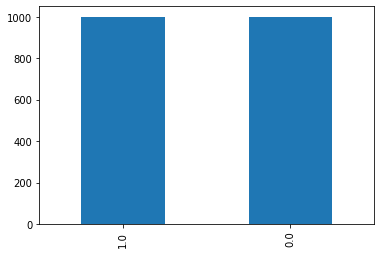

In [ ]:
news['label'].value_counts().plot(kind='bar')
#plt.savefig('img2/data_set_2_news_bar_chart.png', format='png'

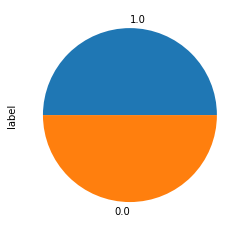

In [ ]:
news['label'].value_counts().plot(kind='pie')
#plt.savefig('img2/data_set_2_news_pie_chart.png', format='png')

'content' and 'label' columns are kept while the rest are dropped as we don't
need them


In [ ]:
data=news.drop(["articleID","domain","date","category","source","relation"],axis=1)

In [ ]:
data

headline  ... label
0            হঠাৎ আফগান ক্রিকেট বোর্ড প্রধানের পদত্যাগ  ...   1.0
1                             টস হেরে বোলিংয়ে বাংলাদেশ  ...   1.0
2                       রাজধানীতে বিশেষ অভিযানে আটক ৪৩  ...   1.0
3    উস্কানি রোধে নজরদারি থাকবে সামাজিক যোগাযোগ মাধ...  ...   1.0
4       'যেখানে তেল আসত ৭ দিনে, এখন তা আসবে অতি দ্রুত'  ...   1.0
..                                                 ...  ...   ...
995  ঈদের ছুটিতে রাস্তাঘাট বেশি ফাঁকা দেখে ডিপ্রেশন...  ...   0.0
996  ঢাকার যানজটকে হাসিমুখে মেনে নিতে গঠিত হলো 'হাস...  ...   0.0
997  স্বঘোষিত নিষেধাজ্ঞার কারণে এবার নৌকায় ভোট দিতে...  ...   0.0
998  অবাধ সুষ্ঠ নির্বাচন হলে বিএনপির সবার জামানত বা...  ...   0.0
999                                   রুবেলের ঈদ গোয়ায়  ...   0.0

[2000 rows x 3 columns]

Analysing the data set shape



In [ ]:
encoded_data = data

In [ ]:
print(data.shape)

(2000, 3)


Assigning label numbers with positive and negative values



In [ ]:
labels_to_sentiment = {0:"negative", 1:"positive"}
def label_decoder(label):
    return labels_to_sentiment[label]
    encoded_data.sentiment = encoded_data.sentiment.apply(lambda x: label_decoder(x))
encoded_data.head(5)

headline  ... label
0          হঠাৎ আফগান ক্রিকেট বোর্ড প্রধানের পদত্যাগ  ...   1.0
1                           টস হেরে বোলিংয়ে বাংলাদেশ  ...   1.0
2                     রাজধানীতে বিশেষ অভিযানে আটক ৪৩  ...   1.0
3  উস্কানি রোধে নজরদারি থাকবে সামাজিক যোগাযোগ মাধ...  ...   1.0
4     'যেখানে তেল আসত ৭ দিনে, এখন তা আসবে অতি দ্রুত'  ...   1.0

[5 rows x 3 columns]

Checking the distribution of the data after the reduction phase

Text(0.5, 1.0, 'Bangla Fake News Sentiment Data Distribution')

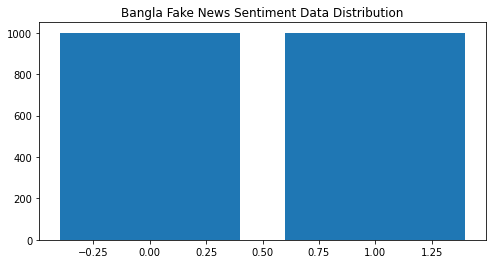

In [ ]:
val_count = encoded_data.label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Bangla Fake News Sentiment Data Distribution")
#plt.savefig('img2/data_set_2_news_distribution_chart.png', format='png')

Picking the right naming convention for the data set before it goes through the text preprocessing stage

In [ ]:
reduced_data = encoded_data
reduced_data.head(5)

headline  ... label
0          হঠাৎ আফগান ক্রিকেট বোর্ড প্রধানের পদত্যাগ  ...   1.0
1                           টস হেরে বোলিংয়ে বাংলাদেশ  ...   1.0
2                     রাজধানীতে বিশেষ অভিযানে আটক ৪৩  ...   1.0
3  উস্কানি রোধে নজরদারি থাকবে সামাজিক যোগাযোগ মাধ...  ...   1.0
4     'যেখানে তেল আসত ৭ দিনে, এখন তা আসবে অতি দ্রুত'  ...   1.0

[5 rows x 3 columns]

In [ ]:
cleaned_data = reduced_data
cleaned_data.head(5)

headline  ... label
0          হঠাৎ আফগান ক্রিকেট বোর্ড প্রধানের পদত্যাগ  ...   1.0
1                           টস হেরে বোলিংয়ে বাংলাদেশ  ...   1.0
2                     রাজধানীতে বিশেষ অভিযানে আটক ৪৩  ...   1.0
3  উস্কানি রোধে নজরদারি থাকবে সামাজিক যোগাযোগ মাধ...  ...   1.0
4     'যেখানে তেল আসত ৭ দিনে, এখন তা আসবে অতি দ্রুত'  ...   1.0

[5 rows x 3 columns]

#Text Preprocessing

Removing stopwords



In [ ]:
stop = set(stopwords.words("bengali"))

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    
    return " ".join(text)

Applying text preprocessing



In [ ]:
cleaned_data["content"] = cleaned_data["content"].apply(remove_stopwords)

Obseving the processed datas

In [ ]:
%load_ext google.colab.data_table
cleaned_data.head(5)


headline  ... label
0          হঠাৎ আফগান ক্রিকেট বোর্ড প্রধানের পদত্যাগ  ...   1.0
1                           টস হেরে বোলিংয়ে বাংলাদেশ  ...   1.0
2                     রাজধানীতে বিশেষ অভিযানে আটক ৪৩  ...   1.0
3  উস্কানি রোধে নজরদারি থাকবে সামাজিক যোগাযোগ মাধ...  ...   1.0
4     'যেখানে তেল আসত ৭ দিনে, এখন তা আসবে অতি দ্রুত'  ...   1.0

[5 rows x 3 columns]

In [ ]:
cleaned_data.content


0      ক্রিকেট বিশ্বের চমকের নাম আফগানিস্তান। বছরে পা...
1      এশিয়া কাপের ষষ্ঠ ম্যাচে বাংলাদেশ দলের বিপক্ষে ...
2      রাজধানীতে মাদক বিরোধী অভিযান পরিচালনা ঢাকা মেট...
3      সনাতন ধর্মাবলম্বীদের সবচেয়ে বড় ধর্মীয় উৎসব দুর...
4      ভারত পাইপ লাইনের সরাসরি দেশে জ্বালানি তেল সরবর...
                             ...                        
995    ঈদের ছুটি মানেই রাস্তাঘাট ফাঁকা, মানুষের ভীড় জ...
996    ঢাকার রাস্তার জ্যাম ঢাকার গর্ব, গিনেসবুকে নাম ...
997    আসন্ন জাতীয় নির্বাচনে নৌকা মার্কায় ভোট পারছেন ...
998    নির্বাচনের সময় নেতাকর্মীরা সাধারণত দল সম্পর্কে...
999    পরিবারের সাথে ঈদ উদযাপন ২৭ই আগষ্ট সকালের ফ্লাই...
Name: content, Length: 2000, dtype: object

#Splitting the Dataset

In [ ]:
train_size = 0.8

Here, we split the dataset into 80% training and 20% testing set then randomise it for balance purpose

In [ ]:
train_data, test_data = train_test_split(cleaned_data, test_size=1-train_size,
                                         random_state=7)

print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1600
Test Data size 400


In [ ]:
train_data.head(10)

headline  ... label
773              এশিয়া কাপ ছেড়ে হঠাৎ দেশে ফিরছেন সাকিব  ...   0.0
13                     মাশরাফী ক্ষুব্ধ, বিসিবি বিস্মিত  ...   1.0
389                    গাজীপুরে জোড়া খুনের ঘটনায় মামলা  ...   1.0
946  পাকিস্তানের বিপক্ষে টস জিতে ব্যাটিংয়ে আফগানিস্তান  ...   1.0
596  বন্যাদুর্গতদের বাঁচিয়ে ইঁদুর-জ্বরে মৃত্যু মৎস্...  ...   1.0
524  ঘুম থেকে উঠে বিছানায় দুটো টিকটিকি দেখে নিজেকে ...  ...   0.0
487  ঘুর্নিঝড় সেন্ডি আল্লাহর গজব: ওবামা | দৈনিক মত...  ...   0.0
889  একদিনে ১২৬৩ বার হস্তমৈথুন করে গিনেস বুক অফ ওয়...  ...   0.0
956            ইয়েমেনি রক্তে ‘মেইড ইন আমেরিকা’র মুনাফা  ...   1.0
696     নিজেকে আত্মবিশ্বাসী রাখতে যে কৌশল প্রয়োগ করবেন  ...   0.0

[10 rows x 3 columns]

#Tokenizer

Hyper parameters

Vocabulary range = 100,000

max length = 500 words

In [ ]:
vocabulary_size = 100000
max_word_length = 500
oov_tk = "<OOV>"
trunc_type='post'
padding_type='post'

Tokenising the training data set



In [ ]:
tokenizer = Tokenizer(num_words = vocabulary_size, oov_token = oov_tk)
tokenizer.fit_on_texts(train_data.content)

word_index = tokenizer.word_index  
vocab_size = len(tokenizer.word_index) + 1

print("Vocabulary Size :", vocab_size)

Vocabulary Size : 58279


Placing the train and test data sets into sequences. 

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_data.content) 
test_sequences = tokenizer.texts_to_sequences(test_data.content)

Padding for handling sentences with different lengths

In [ ]:
x_train = pad_sequences(train_sequences, maxlen=max_word_length, padding=padding_type, truncating=trunc_type)
x_test = pad_sequences(test_sequences, maxlen=max_word_length, padding=padding_type, truncating=trunc_type)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1600, 500)
Testing X Shape: (400, 500)


#Label Encoding

In [ ]:
labels = train_data.label.unique().tolist()

Encoding the sentiment labels



In [ ]:
encoder = LabelEncoder()
encoder.fit(train_data.label.to_list())

y_train = encoder.transform(train_data.label.to_list())
y_test = encoder.transform(test_data.label.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1600, 1)
y_test shape: (400, 1)


Viewing important parameters data



In [ ]:
vocabulary_size =len(word_index)
print('The size of the news dataset vocabulary is: ', vocabulary_size)

The size of the news dataset vocabulary is:  58278


In [ ]:
training_sequence = x_train.shape[1]
print('The length of training sequence is: ', training_sequence)

The length of training sequence is:  500


In [ ]:
print('The length of testing sequence is: ', x_test.shape[1])

The length of testing sequence is:  500


#Pretrained GloVe word embedding

Loading the GloVe word embedding 39-million and 300-dimensional text



In [ ]:
embeddings_index = {}

with open('/content/drive/MyDrive/bn_glove.39M.300d/bn_glove.39M.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 178153 word vectors.


Unique Values



In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 58278 unique tokens.


In [ ]:
embeddings_index

{'ও': array([ 0.438799,  0.457605, -0.13619 , -1.064218,  0.058204, -0.01788 ,
        -0.680954, -0.24028 , -0.345168, -0.289099, -0.397674, -0.071645,
        -0.770083, -1.217952,  0.68862 ,  0.315611,  0.153753,  0.186502,
         1.28256 ,  0.339   ,  0.212145, -0.904182, -0.76271 , -0.660155,
         0.941698,  1.073384,  0.849771,  0.424811,  0.241899,  0.419974,
        -0.005557, -0.498598, -0.57233 , -0.524684,  0.515287, -0.700711,
        -0.248439,  0.346902,  0.207632, -0.986698, -0.028192, -0.103752,
         0.346373, -0.185154, -1.068015,  0.506118,  1.011275,  0.099625,
        -0.514084,  0.500566,  0.119824, -0.556349, -0.021063, -0.258195,
        -0.916759,  0.559662,  0.794105, -0.701388,  0.20626 ,  0.387619,
         0.753678,  0.08988 , -0.584622, -0.440097, -0.012321,  0.192068,
        -0.334506,  0.633277,  0.208412, -0.363502, -0.024673, -0.241967,
         0.378705, -0.048964,  0.072636,  0.16764 ,  0.040773,  0.367837,
        -0.438004,  0.565797,  0.

Creating the embedding matrix



In [ ]:
num_words = len(word_index) + 1
embedding_dimension = 300

embedding_matrix = np.zeros((vocab_size, embedding_dimension))

for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.17295299, -0.260331  ,  0.104678  , ..., -0.150685  ,
         0.043551  ,  0.67578697],
       ...,
       [-0.066323  ,  0.185983  ,  0.084265  , ..., -0.110074  ,
         0.286834  , -0.232794  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

Testing out the embedding matrix

In [ ]:
word_index["ভাল"]

539

In [ ]:
embeddings_index.get("ভাল")

array([-0.483104,  0.058925, -0.22936 , -0.004596,  0.235729,  0.251605,
        0.31166 ,  0.550562, -0.658285,  0.10203 , -0.997152, -0.147583,
       -0.119982,  0.326443, -0.080115,  0.324186,  0.139179,  0.718631,
       -0.010454, -0.008974, -0.28297 , -0.677859, -0.587187, -0.361696,
       -0.221178,  0.057278,  0.846899, -0.120981,  0.002631, -0.309688,
       -0.003483, -0.038529,  0.183552,  0.355005,  0.154271, -0.490927,
        0.050531,  0.037377,  0.048384, -0.362866,  0.13474 , -0.379954,
        0.123369, -0.103365,  0.094077,  0.731221,  0.593186,  0.199917,
        0.488537, -0.212414,  0.209002,  0.28975 , -0.352504, -0.050246,
        0.047122,  0.183759,  0.046067,  0.160182,  0.255329, -0.406269,
       -0.133664, -0.109137,  0.005086, -0.171704, -0.322795, -0.331607,
        0.030534,  0.293672, -0.125707, -0.391665, -0.314022, -0.341243,
        0.35148 , -0.120513,  0.022839, -0.203468, -0.087705, -0.496369,
        0.087848,  0.224077, -0.27079 , -0.031374, 

In [ ]:
(embedding_matrix[539] == embeddings_index.get("ভাল")).all()

True

Observing the training and testing datasets shapes



In [ ]:
print(x_train.shape)
print(y_train.shape)

(1600, 500)
(1600, 1)


In [ ]:
print(x_test.shape)
print(y_test.shape)

(400, 500)
(400, 1)


Checking to see where the training of the model will be done on GPU or CPU



In [ ]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on GPU...


\#Training the four RNN-SVM Models

N.B: The Losses Hinge function converts the encoded labels from 0 to 1 which are negative and positive to -1 and 1.

##Training the LSTM-SVM Model

Creating the LSTM-SVM Model



In [ ]:
LSTM_SVM_model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dimension, 
                            weights=[embedding_matrix], 
                            input_length=max_word_length, 
                            trainable=False),
    
    tf.keras.layers.SpatialDropout1D(0.40),
    tf.keras.layers.LSTM((128), return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM((128)),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1, kernel_regularizer=l2(0.01)),
    tf.keras.layers.Activation('linear')
])

In [ ]:
LSTM_SVM_model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
print(LSTM_SVM_model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          17483700  
                                                                 
 spatial_dropout1d (SpatialD  (None, 500, 300)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 500, 128)          219648    
                                                                 
 dropout (Dropout)           (None, 500, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

Training the LSTM-SVM model



In [ ]:
number_of_epochs = 100
batch_size = 256

LSTM_SVM_history = LSTM_SVM_model.fit(x_train, y_train, 
                                    epochs = number_of_epochs,
                                    batch_size = batch_size,
                   validation_data=(x_test, y_test), 
                                    verbose=1)

Epoch 1/100
7/7 [==============================] - 9s 269ms/step - loss: 1.0201 - accuracy: 0.4988 - val_loss: 1.0198 - val_accuracy: 0.5050
Epoch 2/100
7/7 [==============================] - 1s 137ms/step - loss: 1.0174 - accuracy: 0.4988 - val_loss: 1.0191 - val_accuracy: 0.5050
Epoch 3/100
7/7 [==============================] - 1s 138ms/step - loss: 1.0169 - accuracy: 0.4988 - val_loss: 1.0181 - val_accuracy: 0.5050
Epoch 4/100
7/7 [==============================] - 1s 137ms/step - loss: 1.0148 - accuracy: 0.5006 - val_loss: 1.0169 - val_accuracy: 0.5050
Epoch 5/100
7/7 [==============================] - 1s 138ms/step - loss: 1.0118 - accuracy: 0.5056 - val_loss: 1.0154 - val_accuracy: 0.5125
Epoch 6/100
7/7 [==============================] - 1s 136ms/step - loss: 1.0084 - accuracy: 0.5138 - val_loss: 1.0134 - val_accuracy: 0.5125
Epoch 7/100
7/7 [==============================] - 1s 137ms/step - loss: 1.0062 - accuracy: 0.5169 - val_loss: 1.0121 - val_accuracy: 0.5150
Epoch 8/100
7

Plotting the LSTM-SVM train graph



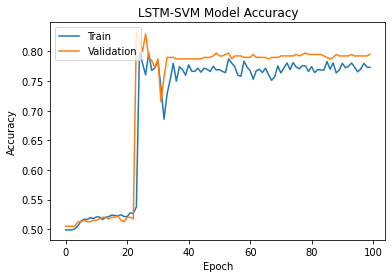

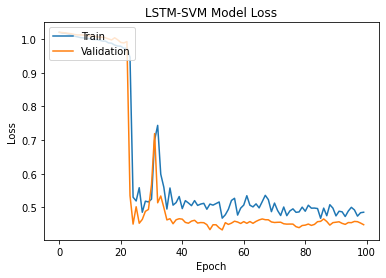

In [ ]:
plt.plot(LSTM_SVM_history.history['accuracy'])
plt.plot(LSTM_SVM_history.history['val_accuracy'])
plt.title('LSTM-SVM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('img2/data_set_2_LSTM_SVM_history_model_accuracy.png', format='png')
plt.show()


plt.plot(LSTM_SVM_history.history['loss'])
plt.plot(LSTM_SVM_history.history['val_loss'])
plt.title('LSTM-SVM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('img2/data_set_2_LSTM_SVM_model_loss.png', format='png')
plt.show()

In [ ]:
#LSTM_SVM_model.save('saved_model2/LSTM_SVM_Model')


In [ ]:
#LSTM_SVM_saved_model = tf.keras.models.load_model('saved_model2/LSTM_SVM_Model')

##Training the Bidirectional LSTM-SVM Model

Creating the Bidirectional LSTM-SVM Model

In [ ]:
BILSTM_SVM_model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dimension, 
                            weights=[embedding_matrix], 
                            input_length=max_word_length, 
                            trainable=False),
    
    tf.keras.layers.SpatialDropout1D(0.40),
    tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(128), return_sequences=True)),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(128))),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1, kernel_regularizer=l2(0.01)),
    tf.keras.layers.Activation('linear')
])

In [ ]:
BILSTM_SVM_model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
print(BILSTM_SVM_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 300)          17483700  
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 500, 300)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional (Bidirectiona  (None, 500, 256)         439296    
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 500, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                      

Training the Bidirectional LSTM-SVM model

In [ ]:
number_of_epochs = 100
batch_size = 256

BILSTM_SVM_history = BILSTM_SVM_model.fit(x_train, y_train, 
                                    epochs = number_of_epochs,
                                    batch_size = batch_size,
                   validation_data=(x_test, y_test), 
                                    verbose=1)

Epoch 1/100
7/7 [==============================] - 27s 3s/step - loss: 1.0154 - accuracy: 0.4988 - val_loss: 0.9964 - val_accuracy: 0.5050
Epoch 2/100
7/7 [==============================] - 23s 3s/step - loss: 0.9933 - accuracy: 0.4988 - val_loss: 0.9711 - val_accuracy: 0.5050
Epoch 3/100
7/7 [==============================] - 23s 3s/step - loss: 0.9735 - accuracy: 0.5031 - val_loss: 0.9393 - val_accuracy: 0.5350
Epoch 4/100
7/7 [==============================] - 22s 3s/step - loss: 0.9354 - accuracy: 0.5425 - val_loss: 0.8909 - val_accuracy: 0.6700
Epoch 5/100
7/7 [==============================] - 22s 3s/step - loss: 0.8911 - accuracy: 0.6331 - val_loss: 0.8222 - val_accuracy: 0.7650
Epoch 6/100
7/7 [==============================] - 23s 3s/step - loss: 0.8185 - accuracy: 0.7244 - val_loss: 0.7684 - val_accuracy: 0.7600
Epoch 7/100
7/7 [==============================] - 23s 3s/step - loss: 0.7444 - accuracy: 0.7531 - val_loss: 0.6159 - val_accuracy: 0.7925
Epoch 8/100
7/7 [==========

Plotting the Bidirectional LSTM-SVM train graph

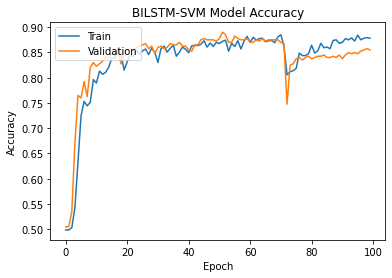

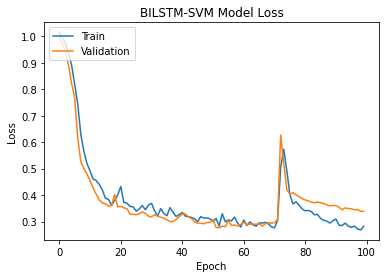

In [ ]:
plt.plot(BILSTM_SVM_history.history['accuracy'])
plt.plot(BILSTM_SVM_history.history['val_accuracy'])
plt.title('BILSTM-SVM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('img2/data_set_2_BILSTM_SVM_model_accuracy.png', format='png')
plt.show()


plt.plot(BILSTM_SVM_history.history['loss'])
plt.plot(BILSTM_SVM_history.history['val_loss'])
plt.title('BILSTM-SVM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('img2/data_set_2_BILSTM_SVM_model_loss.png', format='png')
plt.show()

In [ ]:
#BILSTM_SVM_model.save('saved_model2/BILSTM_SVM_Model')


In [ ]:
#BILSTM_SVM_saved_model = tf.keras.models.load_model('saved_model2/BILSTM_SVM_Model')


##Training the GRU-SVM Model

Creating the GRU-SVM Model



In [ ]:
GRU_SVM_model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dimension, 
                            weights=[embedding_matrix], 
                            input_length=max_word_length, 
                            trainable=False),
    
    tf.keras.layers.SpatialDropout1D(0.40),
    tf.keras.layers.GRU((128), return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.GRU((128)),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1, kernel_regularizer=l2(0.01)),
    tf.keras.layers.Activation('linear')
])

In [ ]:
GRU_SVM_model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
print(GRU_SVM_model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 300)          17483700  
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 500, 300)         0         
 lDropout1D)                                                     
                                                                 
 gru (GRU)                   (None, 500, 128)          165120    
                                                                 
 dropout_4 (Dropout)         (None, 500, 128)          0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                      

Training the GRU-SVM model



In [ ]:
number_of_epochs = 100
batch_size = 256

GRU_SVM_history = GRU_SVM_model.fit(x_train, y_train, 
                                    epochs = number_of_epochs,
                                    batch_size = batch_size,
                   validation_data=(x_test, y_test), 
                                    verbose=1)

Epoch 1/100
7/7 [==============================] - 4s 230ms/step - loss: 1.0192 - accuracy: 0.4988 - val_loss: 1.0195 - val_accuracy: 0.5050
Epoch 2/100
7/7 [==============================] - 1s 114ms/step - loss: 1.0176 - accuracy: 0.4994 - val_loss: 1.0186 - val_accuracy: 0.5050
Epoch 3/100
7/7 [==============================] - 1s 112ms/step - loss: 1.0171 - accuracy: 0.4994 - val_loss: 1.0178 - val_accuracy: 0.5050
Epoch 4/100
7/7 [==============================] - 1s 113ms/step - loss: 1.0160 - accuracy: 0.4994 - val_loss: 1.0170 - val_accuracy: 0.5100
Epoch 5/100
7/7 [==============================] - 1s 114ms/step - loss: 1.0132 - accuracy: 0.5050 - val_loss: 1.0159 - val_accuracy: 0.5075
Epoch 6/100
7/7 [==============================] - 1s 113ms/step - loss: 1.0130 - accuracy: 0.5056 - val_loss: 1.0146 - val_accuracy: 0.5100
Epoch 7/100
7/7 [==============================] - 1s 116ms/step - loss: 1.0089 - accuracy: 0.5144 - val_loss: 1.0135 - val_accuracy: 0.5100
Epoch 8/100
7

Plotting the GRU-SVM train graph



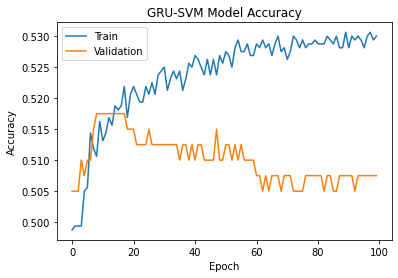

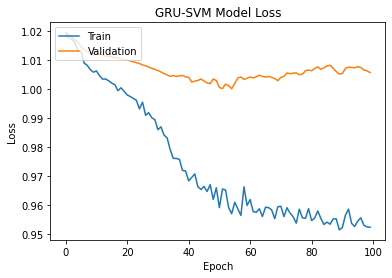

In [ ]:
plt.plot(GRU_SVM_history.history['accuracy'])
plt.plot(GRU_SVM_history.history['val_accuracy'])
plt.title('GRU-SVM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('img2/data_set_2_GRU_SVM_model_accuracy.png', format='png')
plt.show()

plt.plot(GRU_SVM_history.history['loss'])
plt.plot(GRU_SVM_history.history['val_loss'])
plt.title('GRU-SVM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('img2/data_set_2_GRU_SVM_model_loss.png', format='png')
plt.show()

In [ ]:
#GRU_SVM_model.save('saved_model2/GRU_SVM_Model')


In [ ]:
#GRU_SVM_saved_model = tf.keras.models.load_model('saved_model2/GRU_SVM_Model')


##Training the Bidirectional GRU-SVM Model

Creating the Bidirectional GRU-SVM Model


In [ ]:
BIGRU_SVM_model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dimension, 
                            weights=[embedding_matrix], 
                            input_length=max_word_length, 
                            trainable=False),
    
    tf.keras.layers.SpatialDropout1D(0.40),
    tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.GRUCell(128), return_sequences=True)),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.GRUCell(128))),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1, kernel_regularizer=l2(0.01)),
    tf.keras.layers.Activation('linear')
])

In [ ]:
BIGRU_SVM_model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
print(BIGRU_SVM_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 300)          17483700  
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 500, 300)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 500, 256)         330240    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 500, 256)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              296448    
 nal)                                                            
                                                      

Training the Bidirectional GRU-SVM model

In [ ]:
number_of_epochs = 100
batch_size = 256

BIGRU_SVM_history = BIGRU_SVM_model.fit(x_train, y_train, 
                                    epochs = number_of_epochs,
                                    batch_size = batch_size,
                   validation_data=(x_test, y_test), 
                                    verbose=1)

Epoch 1/100
7/7 [==============================] - 33s 4s/step - loss: 1.0088 - accuracy: 0.4988 - val_loss: 0.9917 - val_accuracy: 0.5050
Epoch 2/100
7/7 [==============================] - 28s 4s/step - loss: 0.9803 - accuracy: 0.4988 - val_loss: 0.9617 - val_accuracy: 0.5050
Epoch 3/100
7/7 [==============================] - 28s 4s/step - loss: 0.9564 - accuracy: 0.5063 - val_loss: 0.9276 - val_accuracy: 0.5325
Epoch 4/100
7/7 [==============================] - 28s 4s/step - loss: 0.9127 - accuracy: 0.5369 - val_loss: 0.8852 - val_accuracy: 0.6350
Epoch 5/100
7/7 [==============================] - 27s 4s/step - loss: 0.8732 - accuracy: 0.6119 - val_loss: 0.8362 - val_accuracy: 0.6725
Epoch 6/100
7/7 [==============================] - 28s 4s/step - loss: 0.8225 - accuracy: 0.6681 - val_loss: 0.8039 - val_accuracy: 0.7200
Epoch 7/100
7/7 [==============================] - 27s 4s/step - loss: 0.7841 - accuracy: 0.7069 - val_loss: 0.7609 - val_accuracy: 0.7225
Epoch 8/100
7/7 [==========

Plotting the Bidirectional GRU-SVM train graph



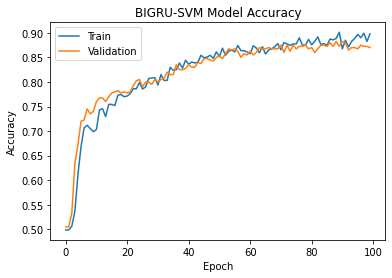

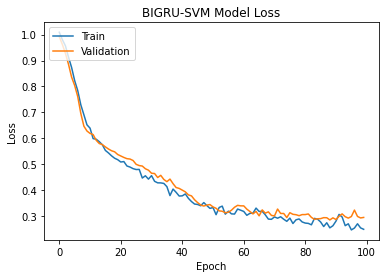

In [ ]:
plt.plot(BIGRU_SVM_history.history['accuracy'])
plt.plot(BIGRU_SVM_history.history['val_accuracy'])
plt.title('BIGRU-SVM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('img2/data_set_2_BIGRU_SVM_model_accuracy.png', format='png')
plt.show()

plt.plot(BIGRU_SVM_history.history['loss'])
plt.plot(BIGRU_SVM_history.history['val_loss'])
plt.title('BIGRU-SVM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('img2/data_set_2_BIGRU_SVM_model_loss.png', format='png')
plt.show()

In [ ]:
#BIGRU_SVM_model.save('saved_model2/BIGRU_SVM_Model')

In [ ]:
#BIGRU_SVM_saved_model = tf.keras.models.load_model('saved_model2/BIGRU_SVM_Model')

#Accuracy Analysis

##LSTM-SVM Accuracy Analysis

Test accuracy and loss



In [ ]:
test_loss, test_acc = LSTM_SVM_model.evaluate(x_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

13/13 [==============================] - 0s 29ms/step - loss: 0.4489 - accuracy: 0.7950
Test Loss: 0.44887667894363403
Test Accuracy: 0.7950000166893005


Testing the hybrid model against the testing data set



In [ ]:
LSTM_SVM_scores = LSTM_SVM_model.predict(x_test, verbose=1, batch_size=256)

2/2 [==============================] - 1s 31ms/step


In [ ]:
LSTM_SVM_scores

array([[ 0.9296386 ],
       [-1.1077542 ],
       [-1.0738087 ],
       [ 0.92963815],
       [-1.073757  ],
       [ 0.92963815],
       [-1.0737846 ],
       [ 0.9296379 ],
       [ 0.92963815],
       [ 0.92963886],
       [ 0.92963815],
       [-1.0737569 ],
       [ 0.9296379 ],
       [-1.3594983 ],
       [ 0.92963874],
       [-1.0737288 ],
       [-1.0737569 ],
       [-1.0737572 ],
       [-1.1003517 ],
       [-1.073757  ],
       [-1.0737594 ],
       [-1.0737569 ],
       [ 0.92963815],
       [-1.0737568 ],
       [ 0.92963815],
       [-1.0737576 ],
       [-1.0743923 ],
       [ 0.92963815],
       [-1.2804595 ],
       [ 0.92963994],
       [-1.1377689 ],
       [ 0.92963815],
       [ 0.92963815],
       [ 0.92963815],
       [ 0.92963815],
       [ 0.92963815],
       [-1.0737569 ],
       [ 0.9296379 ],
       [-1.073757  ],
       [ 0.9296379 ],
       [ 0.9296395 ],
       [ 0.92963815],
       [-1.0737575 ],
       [-1.073757  ],
       [ 0.92963797],
       [ 0

In [ ]:
LSTM_SVM_y_pred=np.where(LSTM_SVM_scores>0.5,1,0)

In [ ]:
LSTM_SVM_y_pred

array([[1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
    

Accuracy

In [ ]:
print(accuracy_score(y_test, LSTM_SVM_y_pred))

0.795


Classification report (Precision, Recall, F1-Score and Accuracy)

In [ ]:
print(classification_report(y_test, LSTM_SVM_y_pred))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       202
           1       0.77      0.83      0.80       198

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.79       400
weighted avg       0.80      0.80      0.79       400



Confusion Matrix

In [ ]:
LSTM_SVM_CM=confusion_matrix(y_test, LSTM_SVM_y_pred)
print(LSTM_SVM_CM)

[[154  48]
 [ 34 164]]


In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalisation
[[154  48]
 [ 34 164]]


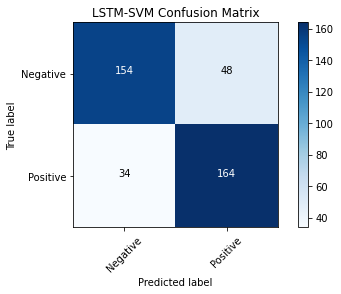

In [ ]:
categories = ['Negative','Positive']
LSTM_SVM_cnf_matrix = confusion_matrix(y_test, LSTM_SVM_y_pred)
plot_confusion_matrix(cm=LSTM_SVM_cnf_matrix, classes=categories, title='LSTM-SVM Confusion Matrix')
#plt.savefig('img2/data_set_2_LSTM_SVM_CM.png', format='png')
plt.show()

##Bidirectional LSTM-SVM Accuracy Analysis

Test accuracy and loss



In [ ]:
test_loss, test_acc = BILSTM_SVM_model.evaluate(x_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

13/13 [==============================] - 4s 271ms/step - loss: 0.3387 - accuracy: 0.8550
Test Loss: 0.33865028619766235
Test Accuracy: 0.8550000190734863


In [ ]:
BILSTM_SVM_scores = BILSTM_SVM_model.predict(x_test, verbose=1, batch_size=256)

2/2 [==============================] - 1s 261ms/step


In [ ]:
BILSTM_SVM_scores

array([[ 1.2495335 ],
       [-1.0753976 ],
       [ 0.48673207],
       [ 1.5947876 ],
       [-1.5908717 ],
       [ 1.6236324 ],
       [-1.201766  ],
       [-1.368227  ],
       [ 1.2646174 ],
       [ 1.6532001 ],
       [ 1.5658553 ],
       [-1.1687349 ],
       [-1.6232531 ],
       [-1.6261961 ],
       [ 1.7428955 ],
       [-1.3053914 ],
       [-1.1726478 ],
       [-1.4774852 ],
       [-1.0884502 ],
       [-1.1457795 ],
       [-1.6280848 ],
       [-1.1328282 ],
       [ 1.6956954 ],
       [-1.358622  ],
       [ 1.6005366 ],
       [-1.4767475 ],
       [-1.5724646 ],
       [ 1.9279735 ],
       [-1.2752861 ],
       [ 1.4325947 ],
       [ 1.4331326 ],
       [ 1.3917091 ],
       [ 1.738068  ],
       [-1.0702113 ],
       [ 1.2571855 ],
       [ 1.407585  ],
       [-1.2037491 ],
       [ 1.6795013 ],
       [-1.3221353 ],
       [ 1.3785499 ],
       [ 1.7467085 ],
       [ 1.6897902 ],
       [-1.0421788 ],
       [-1.2710813 ],
       [-1.4282328 ],
       [ 1

In [ ]:
BILSTM_SVM_y_pred=np.where(BILSTM_SVM_scores>0.5,1,0)

In [ ]:
BILSTM_SVM_y_pred

array([[1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
    

Accuracy

In [ ]:
print(accuracy_score(y_test, BILSTM_SVM_y_pred))

0.855


Classification report (Precision, Recall, F1-Score and Accuracy)

In [ ]:
print(classification_report(y_test, BILSTM_SVM_y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       202
           1       0.88      0.81      0.85       198

    accuracy                           0.85       400
   macro avg       0.86      0.85      0.85       400
weighted avg       0.86      0.85      0.85       400



Confusion Matrix

In [ ]:
BILSTM_SVM_CM=confusion_matrix(y_test, BILSTM_SVM_y_pred)
print(BILSTM_SVM_CM)

[[181  21]
 [ 37 161]]


In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalisation
[[181  21]
 [ 37 161]]


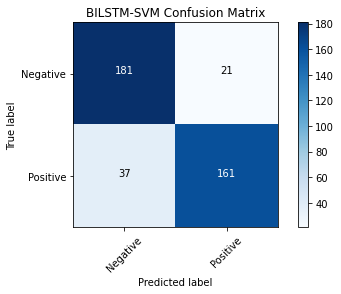

In [ ]:
categories = ['Negative','Positive']
BILSTM_SVM_cnf_matrix = confusion_matrix(y_test, BILSTM_SVM_y_pred)
plot_confusion_matrix(cm=BILSTM_SVM_cnf_matrix, classes=categories, title='BILSTM-SVM Confusion Matrix')
#plt.savefig('img2/data_set_2_BILSTM_SVM_CM.png', format='png')
plt.show()

##GRU-SVM Accuracy Analysis

Test accuracy and loss

In [ ]:
test_loss, test_acc = GRU_SVM_model.evaluate(x_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

13/13 [==============================] - 0s 15ms/step - loss: 1.0056 - accuracy: 0.5075
Test Loss: 1.0055986642837524
Test Accuracy: 0.5074999928474426


Testing the hybrid model against the testing data set

In [ ]:
GRU_SVM_scores = GRU_SVM_model.predict(x_test, verbose=1, batch_size=256)

2/2 [==============================] - 1s 23ms/step


In [ ]:
GRU_SVM_scores

array([[-0.7266468 ],
       [-0.72664684],
       [-0.72664684],
       [-0.7266468 ],
       [-0.7266468 ],
       [-0.7266467 ],
       [-0.7266468 ],
       [-0.72664684],
       [-0.72664666],
       [-0.7266468 ],
       [-0.7266467 ],
       [-0.72664684],
       [-0.7266468 ],
       [-2.1979768 ],
       [-0.7266468 ],
       [-0.7266468 ],
       [-0.72664684],
       [-0.7266468 ],
       [-0.7266467 ],
       [-0.7266468 ],
       [-0.72664684],
       [-0.72664684],
       [-0.7266467 ],
       [-0.7266467 ],
       [-0.7266467 ],
       [-0.7266468 ],
       [-0.7266468 ],
       [-0.72664666],
       [-0.7236535 ],
       [-0.7266468 ],
       [-0.72662646],
       [-0.7266467 ],
       [-0.7266468 ],
       [-0.7266468 ],
       [-0.72664666],
       [-0.72664666],
       [-0.72664684],
       [-0.7266467 ],
       [-0.72664684],
       [-0.7266467 ],
       [-0.7266468 ],
       [-0.72664666],
       [-0.72664684],
       [-0.7266468 ],
       [-0.7266468 ],
       [-0

In [ ]:
GRU_SVM_y_pred=np.where(GRU_SVM_scores>0.5,1,0)

In [ ]:
GRU_SVM_y_pred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

Accuracy

In [ ]:
print(accuracy_score(y_test, GRU_SVM_y_pred))

0.5075


Classification report (Precision, Recall, F1-Score and Accuracy)

In [ ]:
print(classification_report(y_test, GRU_SVM_y_pred))

              precision    recall  f1-score   support

           0       0.51      0.98      0.67       202
           1       0.56      0.03      0.05       198

    accuracy                           0.51       400
   macro avg       0.53      0.50      0.36       400
weighted avg       0.53      0.51      0.36       400



Confusion Matrix

In [ ]:
GRU_SVM_CM=confusion_matrix(y_test, GRU_SVM_y_pred)
print(GRU_SVM_CM)

[[198   4]
 [193   5]]


In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalisation
[[198   4]
 [193   5]]


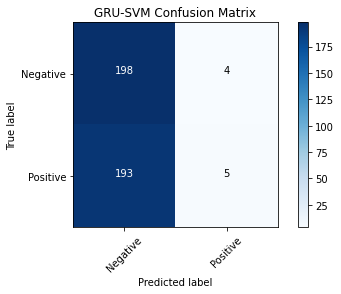

In [ ]:
categories = ['Negative','Positive']
GRU_SVM_cnf_matrix = confusion_matrix(y_test, GRU_SVM_y_pred)
plot_confusion_matrix(cm=GRU_SVM_cnf_matrix, classes=categories, title='GRU-SVM Confusion Matrix')
#plt.savefig('img2/data_set_2_GRU_SVM_CM.png', format='png')
plt.show()

##Bidirectional GRU-SVM Accuracy Analysis

Test accuracy and loss

In [ ]:
test_loss, test_acc = BIGRU_SVM_model.evaluate(x_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

13/13 [==============================] - 4s 315ms/step - loss: 0.2957 - accuracy: 0.8700
Test Loss: 0.29572367668151855
Test Accuracy: 0.8700000047683716


Testing the hybrid model against the testing dataset

In [ ]:
BIGRU_SVM_scores = BIGRU_SVM_model.predict(x_test, verbose=1, batch_size=256)

2/2 [==============================] - 1s 320ms/step


In [ ]:
BIGRU_SVM_scores

array([[-0.3311568 ],
       [-1.2382035 ],
       [ 1.6103722 ],
       [ 2.0669203 ],
       [-1.3404078 ],
       [ 2.0422063 ],
       [-1.6127523 ],
       [-1.5891799 ],
       [ 0.8977495 ],
       [ 1.7438966 ],
       [ 0.93130493],
       [-1.2886195 ],
       [-1.3243246 ],
       [-1.5863816 ],
       [ 2.1623042 ],
       [-1.6373149 ],
       [-1.5739331 ],
       [-1.909984  ],
       [-1.3171095 ],
       [-1.6591003 ],
       [-2.172769  ],
       [-1.4781002 ],
       [ 1.9440941 ],
       [-1.7057517 ],
       [ 1.75267   ],
       [-1.9005837 ],
       [-1.3285903 ],
       [ 2.3929737 ],
       [-1.3713759 ],
       [ 1.6178684 ],
       [ 2.0157588 ],
       [ 1.4924662 ],
       [ 1.9104189 ],
       [-1.0276622 ],
       [ 1.4431851 ],
       [ 1.3185945 ],
       [-1.6904824 ],
       [ 2.0424905 ],
       [-1.6644924 ],
       [ 1.3698362 ],
       [ 2.058645  ],
       [ 2.035387  ],
       [-1.4000287 ],
       [-1.3285117 ],
       [-1.5930638 ],
       [ 1

In [ ]:
BIGRU_SVM_y_pred=np.where(BIGRU_SVM_scores>0.5,1,0)

In [ ]:
BIGRU_SVM_y_pred

array([[0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
    

Accuracy

In [ ]:
print(accuracy_score(y_test, BIGRU_SVM_y_pred))

0.87


Classification report (Precision, Recall, F1-Score and Accuracy)

In [ ]:
print(classification_report(y_test, BIGRU_SVM_y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88       202
           1       0.89      0.84      0.86       198

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



Confusion Matrix

In [ ]:
BIGRU_SVM_CM=confusion_matrix(y_test, BIGRU_SVM_y_pred)
print(BIGRU_SVM_CM)

[[182  20]
 [ 32 166]]


In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalisation
[[182  20]
 [ 32 166]]


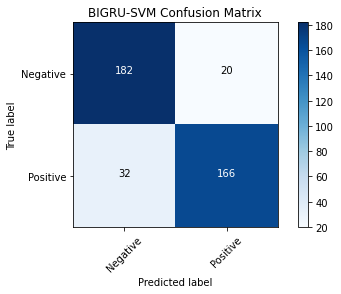

In [ ]:
categories = ['Negative','Positive']
BIGRU_SVM_cnf_matrix = confusion_matrix(y_test, BIGRU_SVM_y_pred)
plot_confusion_matrix(cm=BIGRU_SVM_cnf_matrix, classes=categories, title='BIGRU-SVM Confusion Matrix')
#plt.savefig('img2/data_set_2_BIGRU_SVM_CM.png', format='png')
plt.show()